# ImageRetrieval AutoEncoders

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Image_Retrieval
!ls 

/content/drive/MyDrive/Image_Retrieval
docs			     ImageRetrieval_RESNET.ipynb  lfw-deepfunneled.tgz
ImageRetrieval_CBIR.ipynb    Jim_OBrien_0001.jpg	  lfw.tgz
ImageRetrieval_CNN_BN.ipynb  lfw_attributes.txt		  __pycache__
ImageRetrieval_CNN.ipynb     lfw_dataset.py		  tqdm_utils.py


In [3]:
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L

import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
import matplotlib.pyplot as plt

# Load dataset
Dataset downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [4]:
ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [5]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

**************************************************



In [6]:
def show_image(img):
    plt.imshow(np.clip(img + 0.5, 0, 1))

<ipython-input-7-43dd0313f6a7>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1844

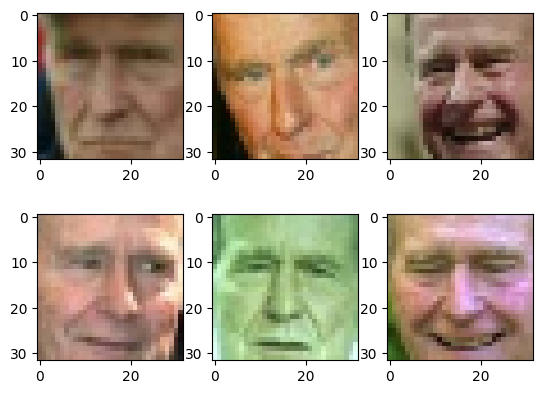

In [7]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# Convolutional autoencoder

## Encoder

The encoder part is pretty straight forward, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size.

## Decoder

For decoder we have used "transpose convolution". 

A patch of an image is used by a traditional convolutional layer to create a number (patch -> number). The goal of "transpose convolution" is to take a number and turn it into an image patch (number -> patch). To "undo" convolutions in the encoder, we require this layer. 

In [8]:
def build_deep_autoencoder(img_shape, code_size):
    """Improved autoencoder for image retrieval. See instructions above."""
    H, W, C = img_shape
    
    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.BatchNormalization())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.BatchNormalization())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.BatchNormalization())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.BatchNormalization())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size, activation='sigmoid'))
    
    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(2*2*256, activation='relu'))
    decoder.add(L.Reshape((2, 2, 256)))
    
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.BatchNormalization())
    
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.BatchNormalization())
    
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.BatchNormalization())
    
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder


In [9]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    tf.keras.backend.clear_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [10]:
tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                        

In [11]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [12]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adam", loss='mse')

### Training with CNN_with_Batch_Normalization

In [14]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                verbose=1)

Epoch 1/25
370/370 [==============================] - 88s 218ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 2/25
370/370 [==============================] - 83s 224ms/step - loss: 0.0133 - val_loss: 0.0124
Epoch 3/25
370/370 [==============================] - 81s 220ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 4/25
370/370 [==============================] - 82s 221ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 5/25
370/370 [==============================] - 92s 249ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 6/25
370/370 [==============================] - 88s 238ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 7/25
370/370 [==============================] - 81s 220ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 8/25
370/370 [==============================] - 82s 222ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 9/25
370/370 [==============================] - 80s 217ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 10/25
370/370 [==============================] - 83s 223ms/step - l

# Image retrieval with KNN

In [15]:
images = X_train
codes = encoder.predict(images) 
assert len(codes) == len(images)

370/370 [==============================] - 13s 34ms/step


In [16]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

In [17]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [18]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

### Testing data

In [33]:
def testing_with_K(img):
  distances,neighbors = get_similar(img,n_neighbors=3)
  found=0
  for i in range(3):
      if(distances[i]<=0.8):
          found=1
          break

  return found


In [ ]:
tot=len(X_test)
count=0

for img in X_test:
  if(testing_with_K(img)==1):
    count=count+1

print(count)

In [36]:
print("Total image on test: ", len(X_test))
print("Simialr image with distance lesser than 0.8 units: ", count)

accuracy = float(count/len(X_test))
precision = float(count/len(X_test))

print('Precision: %.3f' % precision)
print('Accuracy: %.3f' % accuracy)

Total image on test:  1315
Simialr image with distance lesser than 0.8 units:  1093
Precision: 0.831
Accuracy: 0.831


1/1 [==============================] - 0s 26ms/step


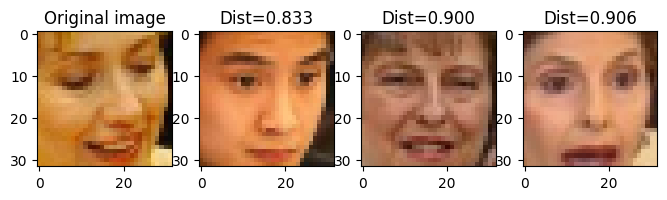

In [28]:
import random 

# picking up random picture
n_rows = len(X_test)
random_index = random.randint(0, n_rows-1)
show_similar(X_test[random_index])

1/1 [==============================] - 0s 25ms/step


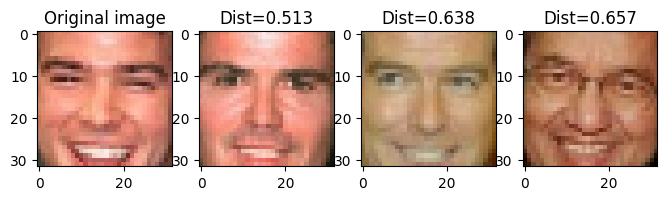

In [29]:
# cherry picked smile images
show_similar(X_test[247])

1/1 [==============================] - 0s 23ms/step


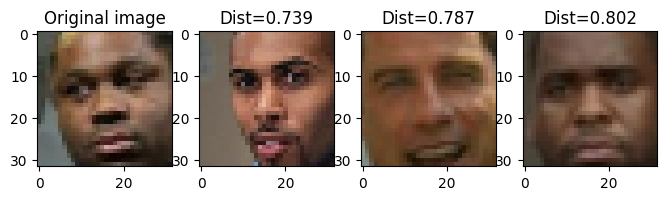

In [30]:
# ethnicity
show_similar(X_test[56])

1/1 [==============================] - 0s 26ms/step


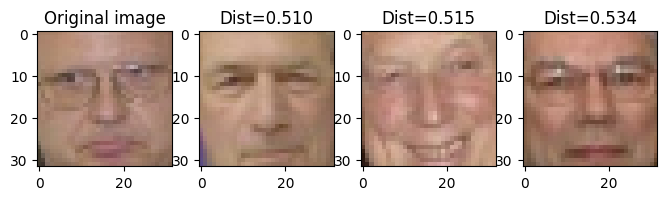

In [31]:
# glasses
show_similar(X_test[63])